In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ****Reading the data****

In [2]:
# Reading the Data 

path = '/kaggle/input/cassava-leaf-disease-classification/'

df_train = pd.read_csv(path + 'train.csv')


# **Reading the Json Data which maps the class for each label**

In [3]:
#Importing json pakkage to handle the json file

import json

json_path = os.path.join(path,'label_num_to_disease_map.json')

#This is used to open the json file and read it 

with open(json_path) as f:
 json_data = json.load(f)                                 #loading the json data
 json_data = {int(k):v for k,v in json_data.items()}      #convert the string value of the key to integer as the dataframe labels are integer

df_train['class_name'] = df_train['label'].map(json_data) #map the json data to the dataframe

In [4]:
#Check how many samples we have for each cass
df_train['class_name'].value_counts()

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: class_name, dtype: int64

# **Visualize the counts for each class**

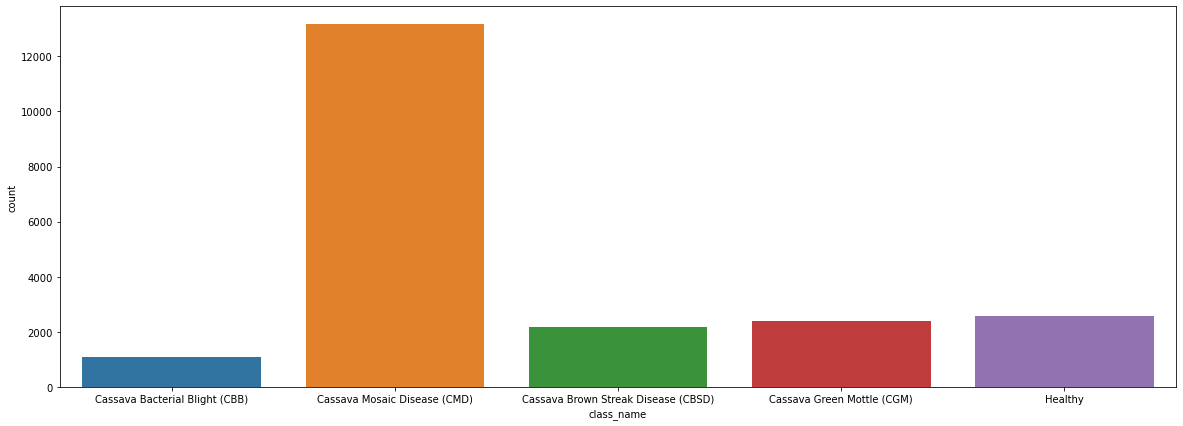

In [5]:
fig=plt.figure(figsize=(20,7))
sns.countplot(data=df_train,x=df_train['class_name'])

# Assigning the image file path to the dataframe

In [6]:
#create a new column for file path
df_train['path'] = (path + 'train_images/'+ df_train['image_id'])

#Below code helps to stop truncating the data
pd.set_option('display.max_colwidth', None)

#strip the empty spaces if any!
df_train['path'] = df_train['path'].str.strip()

# **Visualizing Image**

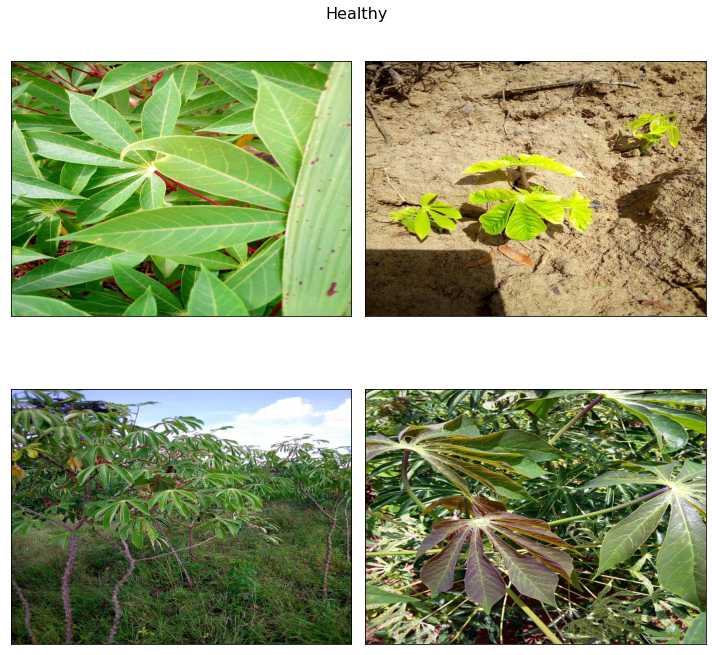

In [7]:
#Define a function to visualise image for each class, which saves repitetion of code.

def visualizer(label_of_class):
    b = df_train[df_train['label'] == label_of_class].iloc[:,3].sample(4)                 #Picks a sample of 4 images randomly
    rows = 2
    cols = 2
    axes=[] 
    plt.figure(figsize=(10,10))
    for a in range(rows*cols):
        plt.suptitle(df_train[df_train['label'] == label_of_class]['class_name'].iloc[1], fontsize=16)     #Sets the main title for the class
        plt.subplot(2,2,a+1)    # the number of images in the grid is 2*2 (4)
        plt.imshow(imread(b.iloc[a])) 
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()   
    plt.show()
    
visualizer(label_of_class = 4)

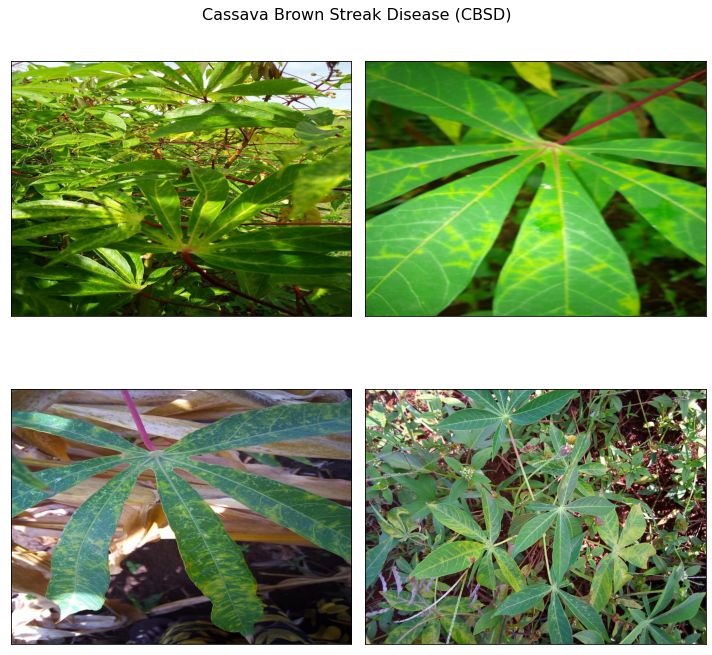

In [8]:
visualizer(1)

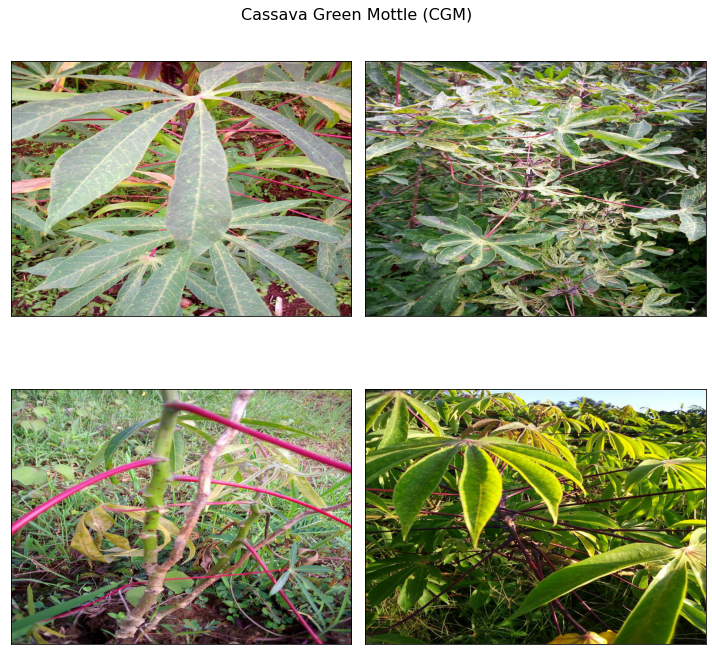

In [9]:
visualizer(2)

# Check the dimensions of the image

In [10]:
#this is going to be the input size of the image
image_shape = (224,224,3)    #3 is the color channel, which is RGB.



# Creating train test splits

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train['path'],df_train['class_name'], test_size=0.15)



In [12]:
#Since we use flow from dataframe, we need to create a dataframe for training and testing
data = {"X_train": X_train, 
        "y_train": y_train} 
training = pd.concat(data, axis = 1)
data_test = {"X_test": X_test, 
           "y_test": y_test}
testing = pd.concat(data_test, axis = 1)

In [14]:
testing['y_test'].value_counts()

Cassava Mosaic Disease (CMD)           1954
Healthy                                 400
Cassava Green Mottle (CGM)              368
Cassava Brown Streak Disease (CBSD)     319
Cassava Bacterial Blight (CBB)          169
Name: y_test, dtype: int64

In [13]:
training['y_train'].value_counts()

Cassava Mosaic Disease (CMD)           11204
Healthy                                 2177
Cassava Green Mottle (CGM)              2018
Cassava Brown Streak Disease (CBSD)     1870
Cassava Bacterial Blight (CBB)           918
Name: y_train, dtype: int64

# Import Necessary Tensorflow packages

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

In [96]:
#Image Data Generator is used to produce more data by tweaking the original data(more the data, better the model :)
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   
                                   shear_range=0.1)

#rotation_range rotates the image, in this case to 20 degrees
#width_shift_range shifts the width of the image to 20 percent in this case
#the same for height_shift_range
#rescale is used to normalise the data between 0 and 1(original data consists of range between 0 and 255)
#zoom_range zooms the image
#fill_mode is used to fill the missing pixels if tweaked
#shear_range, Shear' means that the image will be distorted along an axis, mostly to create or rectify the perception angles.

In [79]:
#Test data just need to be rescaled, we will preprocess it after seeing the performance
test_datagen = ImageDataGenerator(rescale=1./255)

In [84]:
train_generator = train_datagen.flow_from_dataframe(dataframe=training,
                                                    directory="../input/cassava-leaf-disease-classification/train_images",
                                                    x_col="X_train",
                                                    y_col="y_train",
                                                    color_mode='rgb',                                                  
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    interpolation='nearest',
                                                    target_size=image_shape[:2])


Found 18187 validated image filenames belonging to 5 classes.


In [85]:
test_generator = test_datagen.flow_from_dataframe(dataframe=testing,
                                                    directory="../input/cassava-leaf-disease-classification/train_images",
                                                    x_col="X_test",
                                                    y_col="y_test",
                                                    color_mode='rgb',                                                  
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    interpolation='nearest',
                                                    shuffle='False',
                                                    target_size=image_shape[:2])

Found 3210 validated image filenames belonging to 5 classes.


(32, 224, 224, 3)
1.0


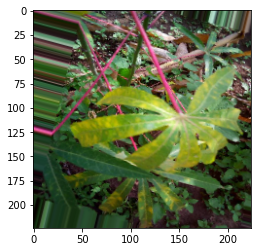

(32, 224, 224, 3)
1.0


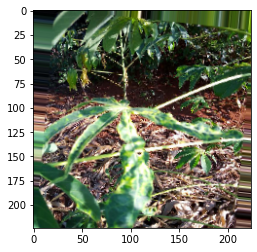

(32, 224, 224, 3)
1.0


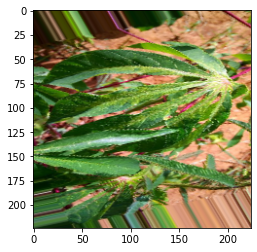

(32, 224, 224, 3)
1.0


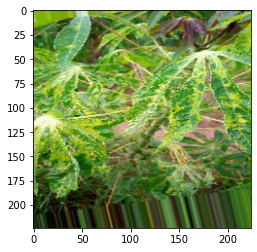

(32, 224, 224, 3)
1.0


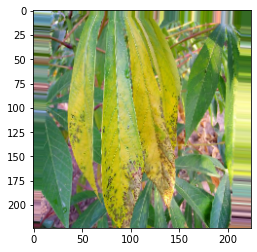

In [86]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)
    print(img.max())
    #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

# Building the model

In [22]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = 'val_loss',
                             verbose = 1,
                             mode = 'min', 
                             save_best_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)

In [ ]:
results = model.fit_generator(train_generator,validation_data=test_generator,callbacks=[early_stop,reduce_lr,checkpoint],epochs=25, steps_per_epoch=len(train_generator),validation_steps=len(test_generator))

In [24]:
from tensorflow import keras

# Transfer-Learning

In [25]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 751 kB/s eta 0:00:01


In [26]:
#Import Efficeintnet 
from keras import applications
import efficientnet.tfkeras as efn

In [94]:
from tensorflow.keras.layers.experimental import preprocessing

img_augmentation = Sequential(
    [
        preprocessing.RandomCrop(120,120),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation"  
)

In [28]:
import tensorflow

In [99]:
#Building the EfficientnrB3 model
model = Sequential()
model.add(tensorflow.keras.layers.InputLayer(input_shape=image_shape))
#model.add(img_augmentation)
model.add(efn.EfficientNetB3(include_top=False, weights='imagenet', drop_connect_rate=0.4))


model1 = Sequential()
model1.add(model)
model1.add(GlobalAveragePooling2D())



model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.3))
model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.3))
 
model1.add(Dense(5,activation='softmax'))

model1.compile(
        optimizer= Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy'])

In [100]:
model1.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1536)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               786944    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)               

In [101]:
results = model1.fit_generator(train_generator,validation_data=test_generator,callbacks=[early_stop,checkpoint],epochs=25, steps_per_epoch=len(train_generator),validation_steps=len(test_generator))

Epoch 1/25
569/569 [==============================] - ETA: 0s - loss: 0.8334 - accuracy: 0.6953
Epoch 00001: val_loss improved from 0.78822 to 0.67573, saving model to best_model.hdf5
569/569 [==============================] - 476s 837ms/step - loss: 0.8334 - accuracy: 0.6953 - val_loss: 0.6757 - val_accuracy: 0.7502
Epoch 2/25
569/569 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.7834
Epoch 00002: val_loss improved from 0.67573 to 0.58159, saving model to best_model.hdf5
569/569 [==============================] - 456s 802ms/step - loss: 0.6064 - accuracy: 0.7834 - val_loss: 0.5816 - val_accuracy: 0.7950
Epoch 3/25
569/569 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.8051
Epoch 00003: val_loss improved from 0.58159 to 0.55606, saving model to best_model.hdf5
569/569 [==============================] - 453s 796ms/step - loss: 0.5382 - accuracy: 0.8051 - val_loss: 0.5561 - val_accuracy: 0.8050
Epoch 4/25
569/569 [=======================

In [103]:
from keras.preprocessing import image

In [111]:
import tensorflow as tf
new_model = tf.keras.models.load_model('./best_model.hdf5')

In [116]:
test_path = '/kaggle/input/cassava-leaf-disease-classification/test_images'
test_images = []
test_image_names = []

for i in os.listdir(test_path):
    test_image_names.append(i)
    img = image.load_img(os.path.join(test_path, i), target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    test_images.append(x)

images = np.vstack([x])
classes = new_model.predict_classes(images, batch_size=10)

In [117]:
sub = pd.concat([pd.Series(test_image_names), pd.Series(classes)], axis=1) 
sub.columns = ['image_id', 'label']
sub.to_csv('submission.csv', index = False)
sub.to_csv('/kaggle/working/submission.csv', index = False)